# Gradienten Verfahren

Die Theorie folgt direkt dem [iFEM](https://github.com/JSchoeberl/iFEM/blob/master/iterative/gradientmethod.ipynb) Jupyter-Notebook, wobei wir für das Beispiel Dirichlet Randbedingungen implementieren.

In this section we assume that $A$ is SPD.


We define the function $f : {\mathbb R}^n \rightarrow {\mathbb R}$ as

$$
f(x) = \tfrac{1}{2} x^T A x - b^T x.
$$

The gradient and Hessian matrix of $f$ are

\begin{eqnarray*}
\nabla f(x) & = & A x - b, \\
\nabla^2 f & = & A.
\end{eqnarray*}

Since $A$ is positive definite, $f$ is convex and there exists a unique minimizer of

$$
\min_{x \in {\mathbb R}} f(x)
$$

characterized by $\nabla f = 0$, i.e. the solution of the linear system $A x = b$. Thus, the linear system is equivalent to the minimization problem.


There holds

$$
f(x) = f(x^\ast) + \tfrac{1}{2} \| x - x^\ast \|_A^2,
$$

which is simply verified by calculation:

\begin{eqnarray}
f(x^\ast) + \tfrac{1}{2} \| x - x^\ast \|_A^2  
& = & \tfrac{1}{2} {x^\ast}^T A x^\ast - b^T x^\ast + \tfrac{1}{2}(x - x^\ast)^T A (x - x^\ast) \\
& = & x^\ast A x^\ast - b^T x^\ast + \tfrac{1}{2} x^T A x - x^T A x^\ast \\
& = & \tfrac{1}{2} x^T A x - b^T x = f(x)
\end{eqnarray}

The error in energy norm is directly related to the distance to the minimum.

We apply the gradient method. The next iterate $x^{k+1}$ is obtained by moving from $x^k$ into the direction of the negative gradient:

\begin{eqnarray*}
x^{k+1} & = & x^k - \alpha \nabla f(x^k) \\
& = & x^k + \alpha r \qquad \text{with} \qquad r = b - A x^k
\end{eqnarray*}

The optimal parameter $\alpha$ can be obtained by line-search:

$$
\min_{\alpha \in {\mathbb R}} f(x^k + \alpha r)
$$

i.e.

$$
\min_\alpha \tfrac{1}{2} (x^k + \alpha r)^T A (x^k + \alpha r) - b^T (x^k + \alpha r)
$$

what is a minimization problem of a convex, quadratic function

$$
\min_{\alpha \in {\mathbb R}} \tfrac{1}{2} r^T A r \, \alpha^2 - (b-A x^k)^T r \, \alpha + \tfrac{1}{2} {x^k}^T A x^k - b^T x^k
$$ 

The optimal value $\alpha_\text{opt}$ is given by
$$
\alpha_\text{opt} = \frac{r^T r}{r^T A r}
$$

The gradient method looks like:

Given $x^0$ <br>
for $k = 0, 1, 2, \ldots$ <br>
$\qquad r = b - A x^k$ <br>
$\qquad \alpha = \frac{r^T r}{r^T A r}$ <br>
$\qquad x^{k+1} = x^k + \alpha r$ <br>

In this version, one needs two matrix-vector products with $A$. By updating the residual one can avoid the second product:

Given $x^0$ <br>
$r^0 = b - A x^0$ <br>
for $k = 0, 1, 2, \ldots$ <br>
$\qquad p = A r^k$ <br>
$\qquad \alpha = \frac{{r^k}^T r^k}{{r^k}^T p}$ <br>
$\qquad x^{k+1} = x^k + \alpha r^k$ <br>
$\qquad r^{k+1} = r^k - \alpha p$ <br>

## Anwendung auf Modellproblem

Wir wenden das Verfahren auf das Modellproblem

$$\begin{split}
-\Delta u + 10\, u & = 1\quad x\in\Omega = [0,1]^2\\
u & = 0\quad x \in \partial\Omega\end{split}$$

an.

In [43]:
from ngsolve import *
from netgen.geom2d import unit_square
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt
from myst_nb import glue

Diskretierung der schwachen Gleichung mit FEM 1. Ordnung:

In [44]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
fes = H1(mesh, order=1, dirichlet='bottom|right|top|left')
u,v = fes.TnT()
a = BilinearForm(grad(u)*grad(v)*dx+10*u*v*dx).Assemble()
f = LinearForm(1*v*dx).Assemble()
gfu = GridFunction(fes)

Wir nutzen das CSR Modul von `scipy` um das reduzierte Problem für die freien Freiheitsgrade zu lösen.

In [45]:
import scipy.sparse as sp
import numpy as np
from numpy.linalg import norm

Für die reduzierte Systemmatrix folgt

In [46]:
rows,cols,vals = a.mat.COO()
ind = np.arange(fes.ndof)[np.array(fes.FreeDofs())]

# Reduktion auf die freien Freiheitsgrade der Systemmatrix
A = sp.csr_matrix((vals,(rows,cols)))
A = A[np.ix_(ind,ind)]
# Reduktion auf die freien Freiheitsgrade der rechten Seite
fd = np.array(f.vec)[ind]

In [49]:
sol = np.zeros(fes.ndof)
r = np.array(fd)
err0 = norm(r)
errs = []
its = 0
while True:
    p = A @ r
    err2 = np.dot(r,r)
    err = sqrt(err2)
    errs.append(err)
    alpha = err2 / np.dot(r,p)
    
    #print ("iteration", its, "res=", err)
    sol[ind] += alpha * r
    r -= alpha * p
    if sqrt(err2) < 1e-8 * err0 or its > 10000: break
    its += 1
print ("needed", its, "iterations")

needed 199 iterations


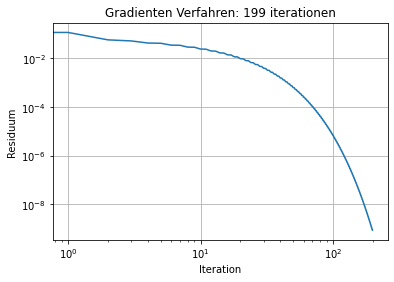

In [50]:
fig, ax = plt.subplots()
ax.loglog(errs)
ax.grid()
ax.set_title('Gradienten Verfahren: '+str(its)+' iterationen')
ax.set_xlabel('Iteration')
ax.set_ylabel('Residuum')
glue("FEM_GradientenVerfahren_fig", fig, display=False)

We observe that the gradient method converges similar fast as the Richardson iteration, but without the need of a good chosen relaxation parameter $\alpha$.

The comparison to Richardson iteration allows also to estimate the error reduction of the gradient method. Let 
$$
\tilde x^{k+1} = x^k - \alpha_\text{Rich} (b - A x^k)
$$
be one step of Richardson. Then

$$
\| x^{k+1} - x^\ast \|_A^2 = 2 \, (f(x^{k+1}) - f(x^\ast)) 
\leq 2 \, ( f (\tilde x^{k+1}) - f(x^\ast) ) = \| \tilde x^{k+1} - x^\ast \|_A^2
$$

One step of the gradient method reduces the error (measured in energy norm) at least as much as one step of the Richardson method.

In [51]:
gfu.vec[:] = sol
Draw(gfu,mesh,'u')

WebGuiWidget(value={'ngsolve_version': '6.2.2104-121-gee6902d12', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, '…

BaseWebGuiScene